Opcional --- Perceptron continuo en TensorFlow for R
===

* *30 min* | Última modificación: Junio 22, 2019

## Dependencias

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Dataset

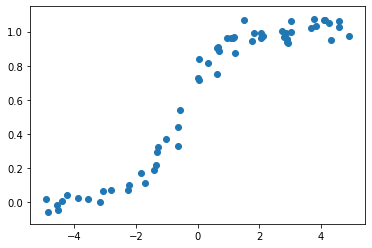

In [5]:
n_samples = 60
np.random.seed(1234)
X = np.random.uniform(-5, 5, n_samples)
d = 1./(1 + np.exp(-(1.0 + 1.53 * X))) + 0.05 * np.random.normal(size=n_samples)
X = np.array([[e] for e in X])
plt.scatter(X, d);

## Implementación en TensorFlow como un modelo general

In [6]:
%%R -i X -i d
## 
## Se importa la librería
##
library(tensorflow)
library(keras)

##
##  Define las constantes y las variables
##
X_ <- tf$constant(cbind(rep(1, length(X)), X)) 
d_ <- tf$constant(matrix(d, length(d), 1)) 
w_ <- tf$Variable(matrix(c(0.001, 0.001), 2, 1))

##
##  Calcula el error
##
SSE <- tf$reduce_sum(tf$square(tf$subtract(d_, tf$nn$sigmoid(tf$matmul(X_, w_)))))

##
##  Inicializa el optimizador
##
opt <- tf$train$GradientDescentOptimizer(learning_rate=0.04)

##
##  Estas son otras opciones de optimizadores que pueden ser utilizados
##
# opt <- tf$train$AdadeltaOptimizer(learning_rate=0.001, rho=0.95, epsilon=1e-08)
# opt <- tf$train$AdagradOptimizer(learning_rate=0.1)
# opt <- tf$train$AdamOptimizer(learning_rate=0.001)

##  Función a optimizar
opt <- opt$minimize(SSE)

##
##  Pronostico
##
x_pred <- seq(from = -8, to = 8, length.out = 50)
X_pred_ <- tf$constant(cbind(rep(1, length(x_pred)), x_pred))
y_pred_ <- tf$nn$sigmoid(tf$matmul(X_pred_, w_))

##
## historia
##
h <- c()

options(repr.plot.width=10, repr.plot.height=4)
par(mfrow=c(1,2))

## estima el modelo
with(tf$Session() %as% sess, {
    sess$run(tf$global_variables_initializer())
    for(i in 1:5000) {
        sess$run(opt)
        h <- c(h, SSE$eval())
        if(i %% 500 == 0)
            print(sess$run(SSE))        
    }
    
    ## grafica de la regresion
    plot(x, d, type='p', pch=21, bg='blue')
    lines(x_pred, y_pred_$eval(), col='red')
})

plot(h, type='l')

R[write to console]: Error in library(keras) : there is no package called ‘keras’
Calls: <Anonymous> -> <Anonymous> -> withVisible -> library




Error in library(keras) : there is no package called ‘keras’
Calls: <Anonymous> -> <Anonymous> -> withVisible -> library


### Solución representado una red neuronal de una neurona usando TensorFlow

En el siguiente código se ilustra la modelación de un perceprón continuo usando Keras en TensorFlow.

In [9]:
%%R

##
## cambia las dimensiones de los vectores
##
x <- matrix(x, length(x), 1)
d <- matrix(d, length(d), 1)


##
## crea la red neuronal como un modelo secuencial de capas
##
model <- keras_model_sequential() 

##
## agrega una capa densa (completamente conectada) de una neurona
## con una entrada y una neurona de salida
##

model %>% 
  layer_dense(units = 1,              # neuronas de la capa actual
              activation = 'sigmoid', # función de activación
              input_shape = c(1))     # neuronas de entrada a la capa

##
## imprime un resumen de la arquitectura del modelo
##
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_3 (Dense)                     (None, 1)                       2           
Total params: 2
Trainable params: 2
Non-trainable params: 0
________________________________________________________________________________


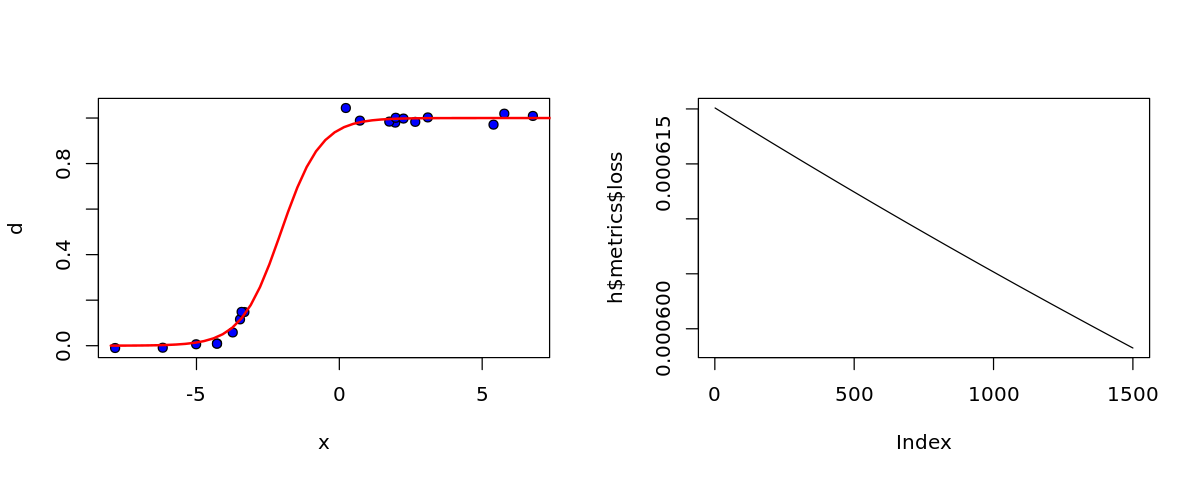

In [25]:
%%R
##
## compila el modelo para poder ejecutarlo
##
model %>% compile(
  loss = 'mse',                         ## funcion a minimizar
  optimizer = optimizer_sgd(lr = 0.1),  ## optimizador
  metrics = c('mse')                    ## metricas de error reportadas
)

##
## entrena el modelo
## 
h <- model %>% fit(
    x, d,           ## patrones de entrenamiento
    epochs=1500,    ## numero máximo de iteraciones
    verbose=0)      ## sin reporte de la ejecución del optimizador

##
## grafica los datos reales y la regresión
##
options(repr.plot.width=10, repr.plot.height=4)
par(mfrow=c(1,2))

x_pred <- seq(from = -8, to = 8, length.out = 50)
X_pred_ <- tf$constant(cbind(rep(1, length(x_pred)), x_pred))
y_pred <- model %>% predict(x_pred)

plot(x, d, type='p', pch=21, bg='blue')
lines(x_pred, y_pred, col='red', lwd=2)

##
## grafica la evolución del error durante
## la optimizacion
##
plot(h$metrics$loss, type = 'l')